---
***
---

# Ensembles: XGBoost and Gradient Boosting

**`XGBoost`**:

`XGBoost` stands for `eXtreme Gradient Boosting`.

*The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost.*

It is an implementation of gradient boosting machines created by Tianqi Chen, now with contributions from many developers. It belongs to a broader collection of tools under the umbrella of the Distributed Machine Learning Community or `DMLC` who are also the creators of the popular `mxnet deep learning library`.

`Tianqi Chen` provides a brief and interesting back story on the creation of XGBoost in the post. [Story and Lessons Behind the Evolution of XGBoost](https://homes.cs.washington.edu/~tqchen/2016/03/10/story-and-lessons-behind-the-evolution-of-xgboost.html)

**XGBoost Features**

The library is laser focused on computational speed and model performance, as such there are few frills. Nevertheless, it does offer a number of advanced features.

**Model Features**

The implementation of the model supports the features of the scikit-learn and R implementations, with new additions like regularization. Three main forms of gradient boosting are supported:

- **Gradient Boosting algorithm** also called gradient boosting machine including the learning rate.
- **Stochastic Gradient Boosting** with sub-sampling at the row, column and column per split levels.
- **Regularized Gradient Boosting** with both L1 and L2 regularization.

**System Features**

The library provides a system for use in a range of computing environments, not least:

- **Parallelization** of tree construction using all of your CPU cores during training.
- **Distributed Computing** for training very large models using a cluster of machines.
- **Out-of-Core Computing** for very large datasets that don’t fit into memory.
- **Cache Optimization** of data structures and algorithm to make best use of hardware.

**Algorithm Features**

The implementation of the algorithm was engineered for efficiency of compute time and memory resources. A design goal was to make the best use of available resources to train the model. Some key algorithm implementation features include:

- **Sparse Aware** implementation with automatic handling of missing data values.
- **Block Structure** to support the parallelization of tree construction.
- **Continued Training** so that you can further boost an already fitted model on new data.


## Problem statement

**`tennis_datasets.zip`**: Archive file consists of two files. 
1. **`tennis_data.csv`**: This dataset includes point outcomes of rallies only (where the number of shots hits exceeds two, which represents the serve and return). This data consists of both men's and women's data about 8000 data points from the past Australian Open Tournament.

2. **`test.csv`**: A Test set.  

### Importing the necessary packages.

In [35]:
import os                       # For operating system related tasks.
import numpy as np              # Numpy for computations.
import pandas as pd             # For data manipulations.
from zipfile import ZipFile     # To uncompress zipfile.

import matplotlib.pyplot as plt # For visualizations.
import seaborn as sns           # For visualizations.

import warnings                   # For warnings.
warnings.filterwarnings('ignore') # Supress/Ignore warnings.

###  Load data.

Loading data and creating dataframe.

Initial data analysis.

In [44]:
tennis_data = pd.read_csv("./tennis_data.csv", 
                          na_values=[-99, '?'],
                          skipfooter=2)

In [45]:
# First five records.
tennis_data.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,ID
0,18,2,F,37.273138,0.574520,0.714819,0.003135,False,False,3.866411,...,3.497863,12.8246,1.6848,True,F,0.575244,False,W,womens,8858
1,3,1,F,31.065932,0.965257,1.272855,0.003296,False,False,4.169818,...,7.524484,12.7580,4.9838,False,U,0.759421,True,W,mens,2538
2,7,1,U,29.987923,1.476366,0.720838,0.003462,True,False,2.553843,...,3.790464,12.4226,1.8314,False,F,0.360206,True,FE,mens,7538
3,6,1,F,34.161657,0.856477,0.047206,0.004221,False,False,2.453661,...,3.513986,12.7934,1.0194,False,B,0.475965,False,W,womens,751
4,7,1,B,32.064804,1.510678,1.173950,0.004764,True,False,1.204516,...,3.158103,12.9232,3.3398,False,F,0.523579,True,UE,mens,7114


In [46]:
# Last five records.
tennis_data.tail()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,ID
7996,8,1,V,23.940228,-0.006189,1.598932,11.883602,False,False,1.972929,...,8.026300,14.9354,2.6766,True,V,0.581914,False,UE,womens,1691
7997,3,1,V,32.392079,-0.011804,3.400310,11.884685,False,False,2.511979,...,6.075379,12.7640,4.2394,False,B,0.596717,True,W,womens,1793
7998,6,1,V,24.721740,0.007159,1.968302,11.885770,False,False,1.397502,...,6.408686,13.0200,3.3784,False,F,0.475700,False,W,mens,1923
7999,4,2,V,31.923515,-0.017215,1.273235,11.885827,False,False,2.983686,...,2.939852,8.9728,4.4620,False,NaN,0.513629,False,W,womens,8503
8000,7,1,V,17.972395,0.001057,2.736833,11.886069,False,False,3.813834,...,6.692719,16.1486,2.6242,True,V,0.799310,True,W,womens,9888


### Shuffling the data.

Shuffle the data, as the data is ordered on men's and women's data.

In [47]:
tennis_data = tennis_data.sample(frac=1)
tennis_data.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,ID
7040,4,2,F,34.939817,-0.065382,2.462026,8.480978,False,False,5.251631,...,2.837907,12.2888,1.9176,False,F,0.514540,False,UE,mens,4969
756,3,2,B,33.922834,0.838569,0.811042,0.558047,False,True,0.506890,...,4.239531,11.5418,3.9844,False,B,0.399701,True,UE,womens,5870
6706,4,1,B,23.518996,0.214878,1.060592,7.913315,False,False,2.604793,...,3.810289,10.0004,2.1868,False,F,0.302662,False,W,mens,1400
369,11,2,F,42.714408,0.759031,1.117970,0.302619,False,True,5.872622,...,6.742295,12.4358,2.4712,False,B,1.349110,True,UE,womens,8780
1129,7,2,B,37.458157,0.938048,1.601707,0.839515,False,True,1.596183,...,1.602631,12.1742,1.9290,False,B,0.438873,True,UE,mens,7021


In [48]:
tennis_data.reset_index(drop = True, inplace=True)
tennis_data.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,ID
0,4,2,F,34.939817,-0.065382,2.462026,8.480978,False,False,5.251631,...,2.837907,12.2888,1.9176,False,F,0.514540,False,UE,mens,4969
1,3,2,B,33.922834,0.838569,0.811042,0.558047,False,True,0.506890,...,4.239531,11.5418,3.9844,False,B,0.399701,True,UE,womens,5870
2,4,1,B,23.518996,0.214878,1.060592,7.913315,False,False,2.604793,...,3.810289,10.0004,2.1868,False,F,0.302662,False,W,mens,1400
3,11,2,F,42.714408,0.759031,1.117970,0.302619,False,True,5.872622,...,6.742295,12.4358,2.4712,False,B,1.349110,True,UE,womens,8780
4,7,2,B,37.458157,0.938048,1.601707,0.839515,False,True,1.596183,...,1.602631,12.1742,1.9290,False,B,0.438873,True,UE,mens,7021


Exploring the data.

In [49]:
# Data dimensions
tennis_data.shape

(8001, 27)

In [50]:
# Feature types.
tennis_data.dtypes

rally                                   int64
serve                                   int64
hitpoint                               object
speed                                 float64
net.clearance                         float64
distance.from.sideline                float64
depth                                 float64
outside.sideline                         bool
outside.baseline                         bool
player.distance.travelled             float64
player.impact.depth                   float64
player.impact.distance.from.center    float64
player.depth                          float64
player.distance.from.center           float64
previous.speed                        float64
previous.net.clearance                float64
previous.distance.from.sideline       float64
previous.depth                        float64
opponent.depth                        float64
opponent.distance.from.center         float64
same.side                                bool
previous.hitpoint                 

In [51]:
tennis_data.nunique()

rally                                   30
serve                                    2
hitpoint                                 4
speed                                 7994
net.clearance                         7994
distance.from.sideline                8001
depth                                 7992
outside.sideline                         2
outside.baseline                         2
player.distance.travelled             7988
player.impact.depth                   7089
player.impact.distance.from.center    6644
player.depth                          6882
player.distance.from.center           5977
previous.speed                        8001
previous.net.clearance                8001
previous.distance.from.sideline       8001
previous.depth                        8001
opponent.depth                        6856
opponent.distance.from.center         6775
same.side                                2
previous.hitpoint                        4
previous.time.to.net                  8001
server.is.i

### Spliting data into train and validations sets.

- Using `train_test_split` method from `sklearn.model_selection` module.

In [52]:
# Seperate target from predictors.
y = tennis_data.outcome
X = tennis_data.drop(['outcome'], axis = 1)

In [53]:
# Divide data into training and validation subsets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      train_size=0.8, 
                                                      test_size=0.2,
                                                      random_state=0)

In [54]:
print('X_train dimensions: ', X_train.shape)
print('y_train dimensions: ', y_train.shape)
print('X_test dimensions:  ', X_valid.shape)
print('y_test dimensions:  ', y_valid.shape)

X_train dimensions:  (6400, 26)
y_train dimensions:  (6400,)
X_test dimensions:   (1601, 26)
y_test dimensions:   (1601,)


### Target value distribution.

- Checking how the target value is distributed both in train and validation sets.

In [55]:
# Function to check the train and validation sets target distributions.
def fn_target_dist(series):
    # Find the counts in each class.
    vcdf = series.value_counts()
    # Convert above to a dataframe.
    vcdf = vcdf.to_frame(name = 'count')
    # Add a new column 'percentage' that gives percentage of level counts.
    vcdf['count%'] = round(100 * vcdf['count']/len(series), 2)

    # Return the target counts dataframe.
    return vcdf

In [56]:
# train target distribution
train_target_dist = fn_target_dist(y_train)
train_target_dist

,count,count%
UE,2811,43.92
W,2140,33.44
FE,1449,22.64


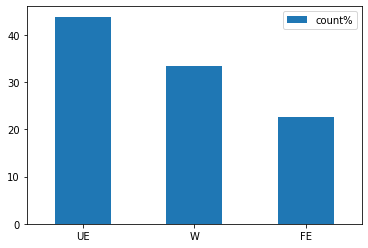

In [57]:
ax = train_target_dist.plot.bar(y='count%', rot=0)

In [58]:
valid_target_dist = fn_target_dist(y_valid)
valid_target_dist

,count,count%
UE,690,43.10
W,542,33.85
FE,369,23.05


In [59]:
train_valid_target_dist = pd.merge(train_target_dist, 
                                   valid_target_dist, 
                                   left_index=True,
                                   right_index=True)
train_valid_target_dist

,count_x,count%_x,count_y,count%_y
UE,2811,43.92,690,43.10
W,2140,33.44,542,33.85
FE,1449,22.64,369,23.05


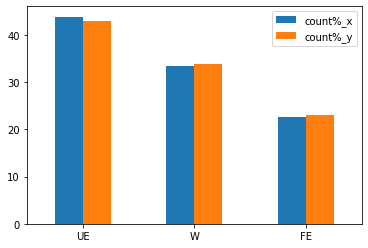

In [60]:
ax = train_valid_target_dist[['count%_x', 'count%_y']].plot.bar(rot=0)

### Finding nulls counts.

- Finding the null counts and percentages in train and test sets.

In [61]:
# Function to count the null values and their percentages in each column.
def fn_nulls_count(df):
    # Nulls counts in each column.
    nulls_counts = df.isnull().sum()
    # Convert above series into dataframe.
    nulls_counts_df = nulls_counts.to_frame(name = 'nulls_count')
    # Add a new column - to get the null counts percentage to the total rows.
    nulls_counts_df['nulls_percentage'] = round(100 * nulls_counts_df['nulls_count']/df.shape[0], 2)
    # Return the null counts dataframe.
    return nulls_counts_df

In [62]:
# Nulls in train data.
train_nulls = fn_nulls_count(X_train)
train_nulls

,nulls_count,nulls_percentage
rally,0,0.00
serve,0,0.00
hitpoint,0,0.00
speed,5,0.08
net.clearance,0,0.00
distance.from.sideline,0,0.00
depth,6,0.09
outside.sideline,0,0.00
outside.baseline,0,0.00
player.distance.travelled,0,0.00


In [63]:
# Nulls in validation data.
validation_nulls = fn_nulls_count(X_valid)
validation_nulls

,nulls_count,nulls_percentage
rally,0,0.00
serve,0,0.00
hitpoint,0,0.00
speed,2,0.12
net.clearance,0,0.00
distance.from.sideline,0,0.00
depth,3,0.19
outside.sideline,0,0.00
outside.baseline,0,0.00
player.distance.travelled,0,0.00


There are no null values both in train and validation sets.

### Identifying the columns for modelling.
- Identifying categorical and numerical columns into lists `categorical_columns` and `numerical_columns`.
- Removing `ID` column(s).

In [64]:
# Finding categorical columns list
categorical_columns = [cname for cname in X_train.columns
                             if X_train[cname].dtype in ['object', 'bool']]
# Adding the column 'serve' to this list - As there are only 2 unique values in this column.
categorical_columns.append('serve')

# Finding numerical columns list
numerical_columns = [cname for cname in X_train.columns
                           if cname not in categorical_columns]

# Removing 'ID' column from the list.
numerical_columns.remove('ID')

# Keeping  selected columns only
cols_to_use = categorical_columns + numerical_columns
X_train_selected = X_train[cols_to_use].copy()
X_valid_selected = X_valid[cols_to_use].copy()

In [65]:
print(categorical_columns)
print("\n")
print(numerical_columns)
print(f"\nThere are {len(categorical_columns)} "
      f"categorical and {len(numerical_columns)} numerical columns.")

['hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 'previous.hitpoint', 'server.is.impact.player', 'gender', 'serve']


['rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 'player.distance.travelled', 'player.impact.depth', 'player.impact.distance.from.center', 'player.depth', 'player.distance.from.center', 'previous.speed', 'previous.net.clearance', 'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 'opponent.distance.from.center', 'previous.time.to.net']

There are 8 categorical and 17 numerical columns.


In [66]:
print(len(X_train_selected.columns))
print(len(X_valid_selected.columns))

25
25


### Target Encoding
- Encoding the target variable into categories or numeric levels.

In [67]:
y_train = y_train.astype('category')
y_valid = y_valid.astype('category')

In [68]:
print(y_train.dtypes)
print(y_valid.dtypes)

category
category


### Implementing Pipelines.

Using `pipelines` to clean up modelling code.

**`Pipelines`**: are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step.

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

- **`Cleaner Code`**: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
- **`Fewer Bugs`**: There are fewer opportunities to misapply a step or forget a preprocessing step.
- **`Easier to Productionize`**: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
- **`More Options for Model Validation`**: Easy to use cross-validation.

constructing the full pipeline in three steps.

**Step 1: Defining Preprocessing Steps**

Similar to how a pipeline bundles together preprocessing and modeling steps, we use the `ColumnTransformer` class to bundle together different preprocessing steps. 

The code below:
- imputes missing values in `numerical data`, and
- imputes missing values and applies a `one-hot encoding` to `categorical data`.

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num_trf', numerical_transformer, numerical_columns),
        ('cat_trf', categorical_transformer, categorical_columns)
    ])

**Step 2: Defining the Model**

Next, defining a random forest model with the familiar `RandomForestClassifier` class.

In [70]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, 
                               random_state=0)

**Step 3: Creating and Evaluate the Pipeline**
    
Using the `Pipeline` class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

- With the pipeline, we preprocess the training data and fit the model in a single line of code. *(In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)*


- With the pipeline, we supply the unprocessed features in `X_valid_selected` to the `predict()` command, and the pipeline automatically preprocesses the features before generating predictions. *(However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)*

In [71]:
from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train_selected, y_train)

# Preprocessing of validation data, get predictions
preds_valid = my_pipeline.predict(X_valid_selected)

# Evaluate the model - validation
score_valid = recall_score(y_valid, preds_valid, average = None)[0]
print('Recall on validation data:', score_valid)

Recall on validation data: 0.7506775067750677


### Model building

Building **`XGBoost`** Model.
(Scikit-learn has another version of gradient boosting, but `XGBoost` has some technical advantages.)

In the code cell, importing the `scikit-learn` API for `XGBoost (xgboost.XGBClassifier)`. This allows us to build and fit a model just as we would in scikit-learn. 

The `XGBClassifier` class has many tunable parameters.

In [72]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

In [73]:
%%time
from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
xgb_pipeline.fit(X_train_selected, y_train)

# Preprocessing of training data, get predictions
preds_train = xgb_pipeline.predict(X_train_selected)

# Evaluate the model - training
score_train = recall_score(y_train, preds_train, average = None)[0]
print('Recall on training data:', score_train)

# Preprocessing of validation data, get predictions
preds_valid = xgb_pipeline.predict(X_valid_selected)

# Evaluate the model - validation
score_valid = recall_score(y_valid, preds_valid, average = None)[0]
print('Recall on validation data:', score_valid)

Recall on training data: 1.0
Recall on validation data: 0.7750677506775068
CPU times: user 19.7 s, sys: 1.92 s, total: 21.6 s
Wall time: 21.7 s


### Parameter Tuning

XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters we should understand is:

`n_estimators`:

`n_estimators`: specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.

Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.

Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the learning_rate parameter discussed next.

In [74]:
%%time
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 15, random_state = 2)

from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
xgb_pipeline.fit(X_train_selected, y_train)

# Preprocessing of training data, get predictions
preds_train = xgb_pipeline.predict(X_train_selected)

# Evaluate the model - training
score_train = recall_score(y_train, preds_train, average = None)[0]
print('Recall on training data:', score_train)

# Preprocessing of validation data, get predictions
preds_valid = xgb_pipeline.predict(X_valid_selected)

# Evaluate the model - validation
score_valid = recall_score(y_valid, preds_valid, average = None)[0]
print('Recall on validation data:', score_valid)

Recall on training data: 0.8875086266390614
Recall on validation data: 0.7669376693766937
CPU times: user 3.65 s, sys: 437 ms, total: 4.08 s
Wall time: 4.63 s


**`early_stopping_rounds`**

`early_stopping_rounds` offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores - this is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping:

In [75]:
%%time
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 500, 
                          early_stopping_rounds=5,
                          random_state = 2,
                          verbosity = 0)

from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
xgb_pipeline.fit(X_train_selected, y_train)

# Preprocessing of training data, get predictions
preds_train = xgb_pipeline.predict(X_train_selected)

# Evaluate the model - training
score_train = recall_score(y_train, preds_train, average = None)[0]
print('Recall on training data:', score_train)

# Preprocessing of validation data, get predictions
preds_valid = xgb_pipeline.predict(X_valid_selected)

# Evaluate the model - validation
score_valid = recall_score(y_valid, preds_valid, average = None)[0]
print('Recall on validation data:', score_valid)

Recall on training data: 1.0
Recall on validation data: 0.7669376693766937
CPU times: user 1min 16s, sys: 7.25 s, total: 1min 23s
Wall time: 1min 13s


**`learning_rate`**

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the `learning rate`) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for `n_estimators` without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets `learning_rate=0.1`.

Modifying the example above to change the learning rate yields the following code:

In [76]:
%%time
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 500,
                          learning_rate = 0.05,
                          early_stopping_rounds=5,
                          random_state = 2,
                          verbosity = 0)

from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
xgb_pipeline.fit(X_train_selected, y_train)

# Preprocessing of training data, get predictions
preds_train = xgb_pipeline.predict(X_train_selected)

# Evaluate the model - training
score_train = recall_score(y_train, preds_train, average = None)[0]
print('Recall on training data:', score_train)

# Preprocessing of validation data, get predictions
preds_valid = xgb_pipeline.predict(X_valid_selected)

# Evaluate the model - validation
score_valid = recall_score(y_valid, preds_valid, average = None)[0]
print('Recall on validation data:', score_valid)

Recall on training data: 0.9993098688750862
Recall on validation data: 0.7669376693766937
CPU times: user 1min 23s, sys: 10.1 s, total: 1min 33s
Wall time: 1min 33s


**`n_jobs`**

On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter n_jobs equal to the number of cores on your machine. On smaller datasets, this won't help.

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.

Here's the modified example:

In [77]:
%%time
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 500,
                          learning_rate = 0.05,
                          early_stopping_rounds=5,
                          n_jobs = 4,
                          random_state = 2,
                          verbosity = 0)

from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
xgb_pipeline.fit(X_train_selected, y_train)

# Preprocessing of training data, get predictions
preds_train = xgb_pipeline.predict(X_train_selected)

# Evaluate the model - training
score_train = recall_score(y_train, preds_train, average = None)[0]
print('Recall on training data:', score_train)

# Preprocessing of validation data, get predictions
preds_valid = xgb_pipeline.predict(X_valid_selected)

# Evaluate the model - validation
score_valid = recall_score(y_valid, preds_valid, average = None)[0]
print('Recall on validation data:', score_valid)

Recall on training data: 0.9993098688750862
Recall on validation data: 0.7669376693766937
CPU times: user 58.7 s, sys: 4.42 s, total: 1min 3s
Wall time: 1min 7s


**`GridSearchCV`**

Here I'm using GridSearchCV on the pipeline and training it on training set. 

I'm using 5-fold cross validation by passing the argument cv=5 in the GridSearchCV. 

The param_grid is the dictionary for the values of parameters that I want to compare. 

In [78]:
%%time
from xgboost import XGBClassifier

xgb_model = XGBClassifier(early_stopping_rounds=5,
                          n_jobs = 4,
                          random_state = 2,
                          verbosity = 0)

from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

CPU times: user 2.59 ms, sys: 257 µs, total: 2.85 ms
Wall time: 1.39 ms


In [79]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_estimators": [10, 50, 100, 500],
    "model__learning_rate": [0.05, 0.1, 0.5, 1],
}

searchCV = GridSearchCV(xgb_pipeline, 
                        cv=5, 
                        param_grid=param_grid)

searchCV.fit(X_train_selected, y_train)  

CPU times: user 16min 26s, sys: 1min 1s, total: 17min 28s
Wall time: 13min 41s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_trf',
                                                                         SimpleImputer(add_indicator=False,
                                                                                       copy=True,
                                                                                       fill_value=None,
                                                                                       missing_values=nan,
                                                   

In [80]:
searchCV.best_params_

{'model__learning_rate': 0.1, 'model__n_estimators': 100}

In [81]:
searchCV.cv_results_['mean_test_score']

array([0.8496875 , 0.85890625, 0.86296875, 0.86796875, 0.85390625,
       0.86515625, 0.8690625 , 0.8678125 , 0.86109375, 0.8646875 ,
       0.864375  , 0.8653125 , 0.86015625, 0.8625    , 0.863125  ,
       0.864375  ])

In [82]:
searchCV.cv_results_['mean_test_score'].mean()

0.862568359375

In [83]:
xgb_grid_model = searchCV.best_estimator_

In [84]:
# Preprocessing of training data, get predictions
preds_train = xgb_grid_model.predict(X_train_selected)

# Evaluate the model - training
score_train = recall_score(y_train, preds_train, average = None)[0]
print('Recall on training data:', score_train)

# Preprocessing of validation data, get predictions
preds_valid = xgb_grid_model.predict(X_valid_selected)

# Evaluate the model - validation
score_valid = recall_score(y_valid, preds_valid, average = None)[0]
print('Recall on validation data:', score_valid)

Recall on training data: 0.9461697722567288
Recall on validation data: 0.7696476964769647


### Build final model.

In [85]:
print(X_train_selected.shape, X_valid_selected.shape)
print(y_train.shape, y_valid.shape)

(6400, 25) (1601, 25)
(6400,) (1601,)


In [86]:
X_train_all = pd.concat([X_train_selected, X_valid_selected])
y_train_all = pd.concat([y_train, y_valid])

print(X_train_all.shape, y_train_all.shape)

(8001, 25) (8001,)


In [87]:
%%time 
final_y_train = y_train_all.astype('category')

CPU times: user 432 µs, sys: 30 µs, total: 462 µs
Wall time: 456 µs


In [88]:
%%time
from xgboost import XGBClassifier

final_xgb_model = XGBClassifier(n_estimators = 500,
                                learning_rate = 0.05,
                                early_stopping_rounds=5,
                                n_jobs = 4,
                                random_state = 2,
                                verbosity = 0)

from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline_final = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', final_xgb_model)
                             ])

# Preprocessing of training data, fit model 
xgb_pipeline_final.fit(X_train_all, final_y_train)

# Preprocessing of training data, get predictions
preds_train_final = xgb_pipeline_final.predict(X_train_all)

# Evaluate the model - training
score_train_final = recall_score(final_y_train, preds_train_final, average = None)[0]
print('Recall on training data:', score_train_final)

Recall on training data: 0.9966996699669967
CPU times: user 38.7 s, sys: 78.2 ms, total: 38.8 s
Wall time: 9.83 s


### Test predictions
- Deriving the test predictions.
- Writing the predictions to csv file in the prescribed format.

In [89]:
# Read Test data
test_data = pd.read_csv("./test.csv")
test_data.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.distance.from.sideline,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,gender,ID
0,3,1,F,39.270591,0.401144,1.170416,1.571232,False,False,5.192466,...,0.261617,6.989702,11.5324,4.3578,False,F,0.792983,True,womens,2
1,5,1,F,28.878268,1.301786,0.239005,3.369407,True,False,2.710977,...,1.639397,5.235990,12.5762,0.9430,False,B,0.488771,True,womens,42
2,5,1,B,29.198360,0.862787,1.717340,2.888382,True,False,1.971893,...,1.863926,2.181455,13.2846,1.2082,False,B,0.497612,True,womens,64
3,9,1,F,32.840471,-0.097965,0.835676,6.535893,False,False,3.125638,...,0.939371,4.667253,11.1782,1.8852,False,B,0.519849,True,womens,103
4,3,1,B,34.871165,0.360966,0.473438,2.123633,False,False,4.189340,...,1.608326,8.221293,11.9924,3.2314,False,F,1.132238,True,womens,106


In [90]:
Final_X_test = test_data[cols_to_use]
#
test_pred = xgb_pipeline_final.predict(Final_X_test)

In [91]:
test_pred[0:10]

array(['W', 'UE', 'UE', 'FE', 'W', 'UE', 'UE', 'FE', 'UE', 'FE'],
      dtype=object)

In [92]:
submissions_df = pd.DataFrame({'ID': test_data.ID, 'outcome': test_pred})
submissions_df.to_csv("test_predictions.csv", index=None)
submissions_df.head()

,ID,outcome
0,2,W
1,42,UE
2,64,UE
3,103,FE
4,106,W


## Partial dependency plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

In [94]:
X_train_selected.dtypes

hitpoint                               object
outside.sideline                         bool
outside.baseline                         bool
same.side                                bool
previous.hitpoint                      object
server.is.impact.player                  bool
gender                                 object
serve                                   int64
rally                                   int64
speed                                 float64
net.clearance                         float64
distance.from.sideline                float64
depth                                 float64
player.distance.travelled             float64
player.impact.depth                   float64
player.impact.distance.from.center    float64
player.depth                          float64
player.distance.from.center           float64
previous.speed                        float64
previous.net.clearance                float64
previous.distance.from.sideline       float64
previous.depth                    

In [95]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

feature_names = [i for i in X_train_selected.columns if X_train_selected[i].dtype in ['int64', 'float64']]
feature_names.remove('serve')
#
X_train_less = X_train_selected[feature_names]
#
val1 = X_train_less.speed.mean()
val2 = X_train_less.depth.mean()
#
X_train_less.fillna({'speed': val1, 
               'depth': val2},
              inplace = True)
# X_less.isnull().sum()

tree_model = DecisionTreeClassifier(random_state=0, 
                                    max_depth=5, 
                                    min_samples_split=5)
tree_model.fit(X_train_less, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [96]:
feature_names

['rally',
 'speed',
 'net.clearance',
 'distance.from.sideline',
 'depth',
 'player.distance.travelled',
 'player.impact.depth',
 'player.impact.distance.from.center',
 'player.depth',
 'player.distance.from.center',
 'previous.speed',
 'previous.net.clearance',
 'previous.distance.from.sideline',
 'previous.depth',
 'opponent.depth',
 'opponent.distance.from.center',
 'previous.time.to.net']

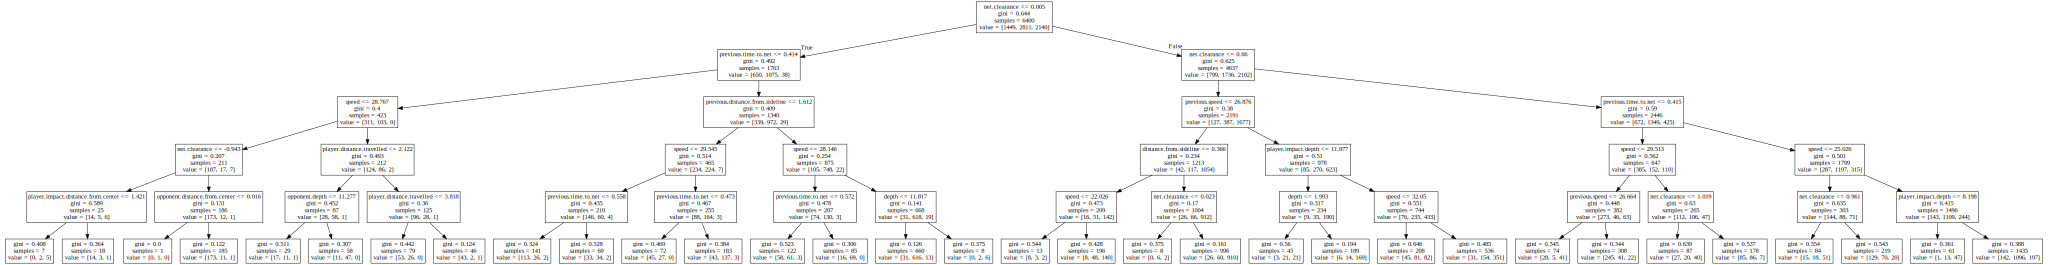

In [97]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, 
                                  out_file=None, 
                                  feature_names=feature_names)
graphviz.Source(tree_graph)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


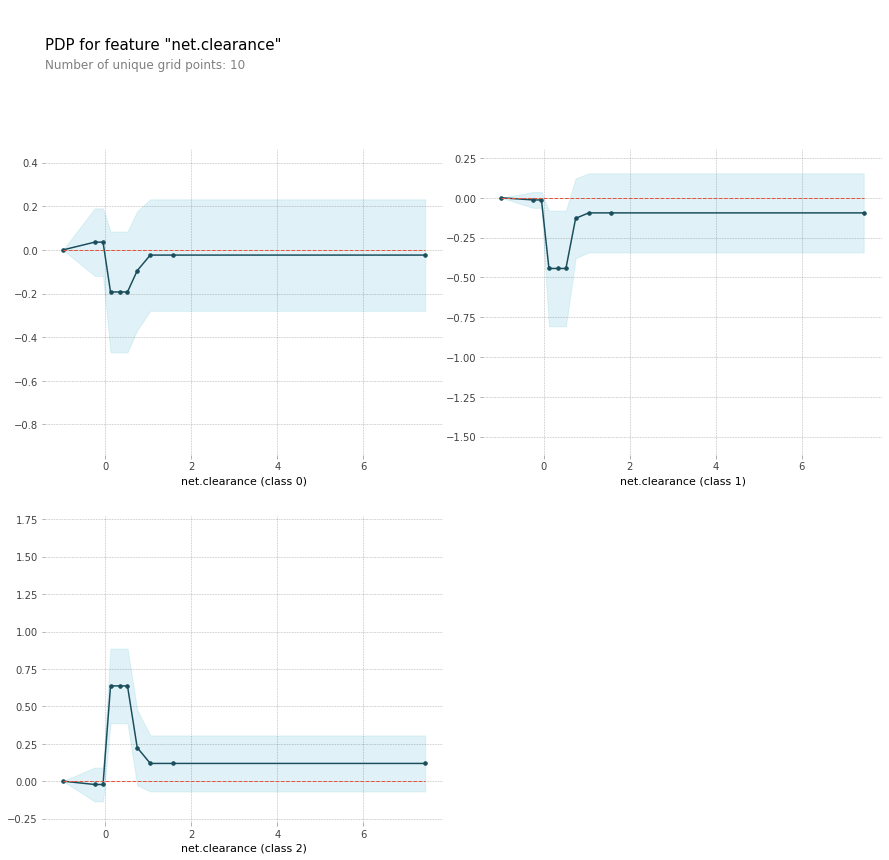

In [98]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

X_valid_less = X_valid_selected[feature_names]

X_valid_less.fillna({'speed': val1, 
                     'depth': val2},
                      inplace = True)
# X_less.isnull().sum()

# Create the data that we will plot
pdp_nc = pdp.pdp_isolate(model=tree_model, 
                            dataset = X_valid_less, 
                            model_features=feature_names, 
                            feature='net.clearance')

# plot it
pdp.pdp_plot(pdp_nc, 'net.clearance')
plt.show()

**`net.clearance`**: Distance above the net as pointending shot passed the net.
*Continuous (cm) distance above net. Can be negative if shot did not pass above the net.*
    
A few items are worth pointing out as you interpret this plot

- The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
- A blue shaded area indicates level of confidence

From this particular graph, we see that the negative `net.clearance < 1cm` leads to forced errors. Beyond 1 cm doesnot make any difference.

Comparing the structure or implications of different models. Here is the same plot with a Random Forest model

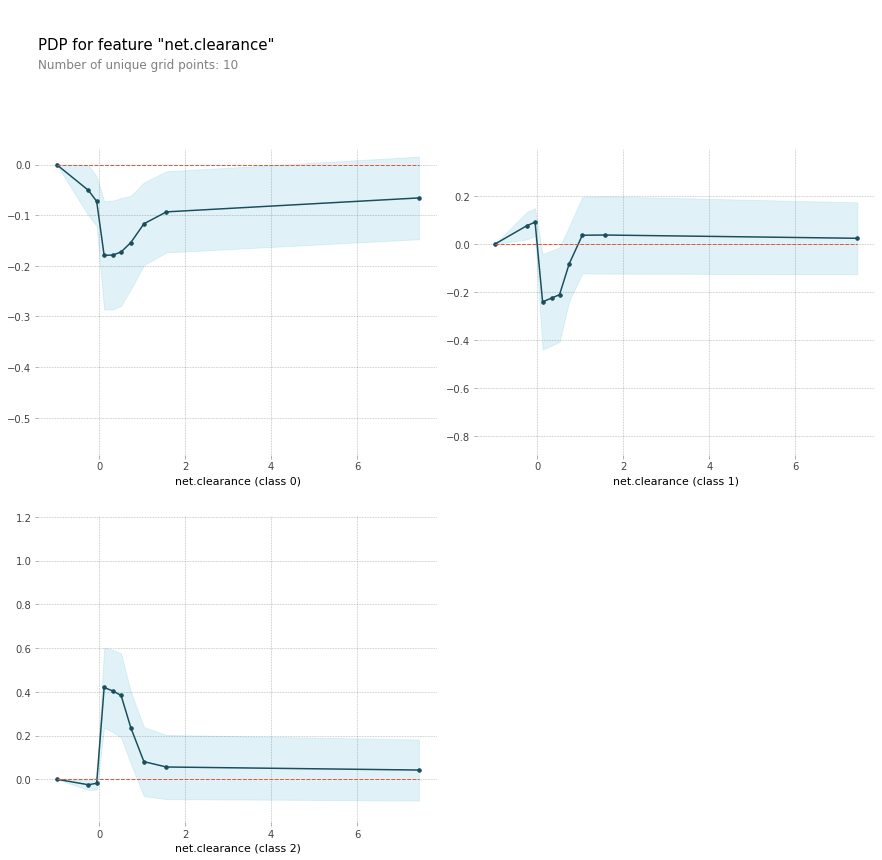

In [99]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(X_train_less, y_train)

pdp_dist = pdp.pdp_isolate(model=rf_model, 
                           dataset=X_valid_less, 
                           model_features=feature_names, 
                           feature='net.clearance')

pdp.pdp_plot(pdp_dist, 'net.clearance')
plt.show()

**2D Partial Dependence Plots**

Interactions between features can be caught by 2D partial dependence plots. 

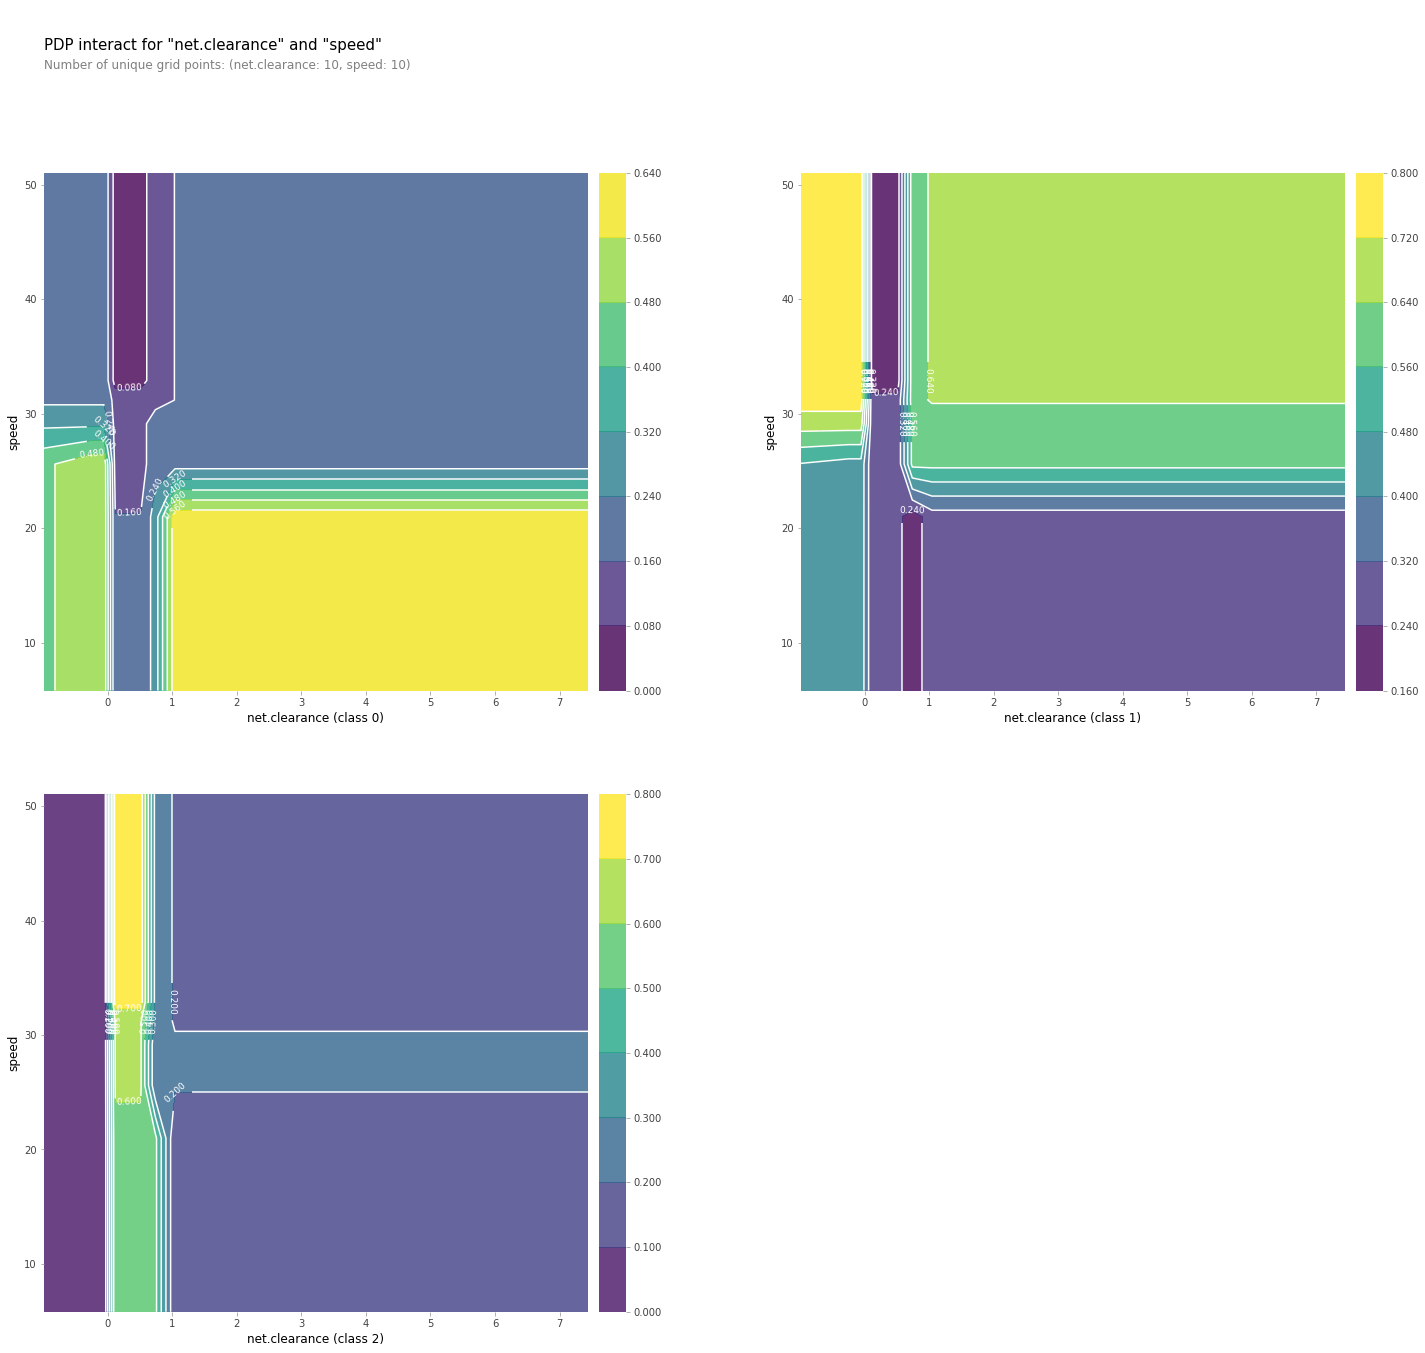

In [100]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['net.clearance', 'speed']
#
inter1  =  pdp.pdp_interact(model=tree_model, 
                            dataset=X_valid_less, 
                            model_features=feature_names, 
                            features=features_to_plot)
#
pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                      feature_names=features_to_plot, 
                      plot_type='contour',
                      figsize = (24, 24))
plt.show()

This graph shows predictions for any combination of `net.clearance` and `speed`.

For example, we see the highest predictions of `win` when the net.clearance is less than 2 cms and speed doesn't matter.


## LightGBM
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

In [101]:
%%time
from lightgbm import LGBMClassifier


lgbm_model = LGBMClassifier(n_estimators = 500,
                            learning_rate = 0.05,
                            n_jobs = 4,
                            random_state = 2)

from sklearn.metrics import recall_score

# Bundle preprocessing and modeling code in a pipeline
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', lgbm_model)])

# Preprocessing of training data, fit model 
lgbm_pipeline.fit(X_train_all, final_y_train)

# Preprocessing of training data, get predictions
preds_train_lgbm = lgbm_pipeline.predict(X_train_all)

# Evaluate the model - training
score_train_lgbm = recall_score(final_y_train, preds_train_lgbm, average = None)[0]
print('Recall on training data:', score_train_lgbm)

Recall on training data: 0.9994499449944995
CPU times: user 13.8 s, sys: 235 ms, total: 14 s
Wall time: 3.62 s


In [102]:
test_pred = lgbm_pipeline.predict(Final_X_test)
originals = pd.read_csv("./test_originals.csv")
originals['outcome'] = originals.outcome.astype('category')
test_recall = recall_score(originals.outcome, test_pred, average = None)[0]
print('Recall score :', round(test_recall,2))

Recall score : 1.0
